In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from Oracle_Assignment_2 import q2_get_mnist_jpg_subset

## Loading Data

In [2]:
Q2_data = q2_get_mnist_jpg_subset(23684)

Failed to download ZIP: HTTPConnectionPool(host='10.24.32.171', port=8000): Max retries exceeded with url: /q2?srn=23684 (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f6772e31910>: Failed to establish a new connection: [Errno 111] Connection refused'))
<zipfile.ZipFile filename='./q2_data.zip' mode='r'>
Extracted ZIP contents to q2_data


## Converting Images to Numpy arrays

In [28]:
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2

data_folder = "q2_data"
data = [] 

for i in range(10):
    folder_path = os.path.join(data_folder, str(i))
    images = []

    for img_name in sorted(os.listdir(folder_path)):
        img_path = os.path.join(folder_path, img_name)

        if img_name.endswith(".jpg"):
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            images.append(img)

    data.append(np.array(images))

data = np.array(data)
print(data.shape)

(10, 1000, 28, 28)


## Multi Layer Perceptron

In [29]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split


images = data.reshape(-1, 28, 28)
labels = np.repeat(np.arange(10), 1000)

# Split 
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

X_train = torch.from_numpy(X_train).float().view(-1, 28*28)
X_test = torch.from_numpy(X_test).float().view(-1, 28*28)
y_train = torch.from_numpy(y_train).long()
y_test = torch.from_numpy(y_test).long()

# DataLoaders
batch_size = 64
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Neural_Network = nn.Sequential(
    nn.Linear(28*28, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 10)
)

criterion = nn.CrossEntropyLoss() # Cross-entropy loss
optimizer = torch.optim.Adam(Neural_Network.parameters(), lr=0.001) 


epochs = 20
for epoch in range(epochs):
    Neural_Network.train()
    curr_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = Neural_Network(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        curr_loss += loss.item() * images.size(0)
    
    epoch_loss = curr_loss / len(train_loader.dataset)

# Evaluation
Neural_Network.eval()
correct = 0
total = 0

for images, labels in test_loader:
    outputs = Neural_Network(images)
    probabilities = F.softmax(outputs, dim=1)
    temp, predicted = torch.max(probabilities, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print("Accuracy of the model on the test set:", (correct / total))

Accuracy of the model on the test set: 0.946


## CNN

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np


X_train = X_train.view(-1, 1, 28, 28)
X_test = X_test.view(-1, 1, 28, 28)

# CNN Model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


cnn_model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.001)

epochs = 20
for epoch in range(epochs):
    cnn_model.train()
    curr_loss = 0.0
    for images, labels in train_loader:
        images = images.view(-1, 1, 28, 28)
        optimizer.zero_grad()
        outputs = cnn_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        curr_loss += loss.item() * images.size(0)
    
    epoch_loss = curr_loss / len(train_loader.dataset)


cnn_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.view(-1, 1, 28, 28)
        outputs = cnn_model(images)
        probabilities = F.softmax(outputs, dim=1)
        temp, predicted = torch.max(probabilities, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print("Accuracy of the CNN model on the test set:", (correct / total))

Accuracy of the CNN model on the test set: 0.9725


## PCA

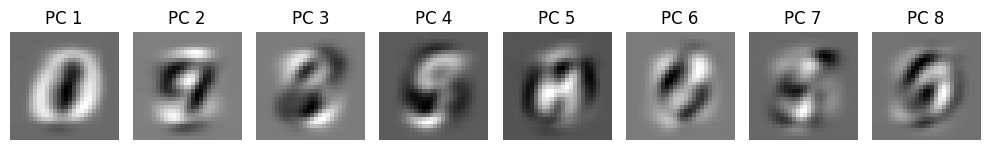

In [31]:
import torch
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split


images_flat = data.reshape(data.shape[0] * data.shape[1], -1)
labels_flat = np.repeat(np.arange(10), 1000)

n_components = 50 
pca = PCA(n_components=n_components)
pca_features = pca.fit_transform(images_flat)


X_train, X_test, y_train, y_test = train_test_split(pca_features, labels_flat, test_size=0.2, random_state=42, stratify=labels_flat)


X_train = torch.from_numpy(X_train).float()
X_test = torch.from_numpy(X_test).float()
y_train = torch.from_numpy(y_train).long()
y_test = torch.from_numpy(y_test).long()


batch_size = 64
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


plt.figure(figsize=(10, 5))
for i in range(min(8, n_components)):
    plt.subplot(1, 8, i+1)
    plt.imshow(pca.components_[i].reshape(28, 28), cmap='gray')
    plt.title(f'PC {i+1}')
    plt.axis('off')
plt.tight_layout()
plt.show()

## MLP with PCA

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class MLP_With_PCA(nn.Module):
    def __init__(self, input_size=50):
        super(MLP_With_PCA, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Create MLP model with PCA features
mlp_pca_model = MLP_With_PCA(input_size=n_components)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp_pca_model.parameters(), lr=0.001)

# Training
epochs = 30
for epoch in range(epochs):
    mlp_pca_model.train()
    curr_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = mlp_pca_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        curr_loss += loss.item() * images.size(0)
    
    epoch_loss = curr_loss / len(train_loader.dataset)


mlp_pca_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = mlp_pca_model(images)
        probabilities = F.softmax(outputs, dim=1)
        temp, predicted = torch.max(probabilities, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print("Accuracy of the MLP model with PCA features on the test set:", (correct / total))

Accuracy of the MLP model with PCA features on the test set: 0.9455


## Logistic Regression with PCA

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import OneHotEncoder


class Logistic_Regression_with_PCA(nn.Module):
    def __init__(self, input_size=50, num_classes=10):
        super(Logistic_Regression_with_PCA, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, x):
        return self.linear(x)


class one_vs_rest:
    def __init__(self, input_size=50):
        self.classifiers = [nn.Linear(input_size, 1) for _ in range(10)]
        self.optimizers = [torch.optim.Adam(c.parameters(), lr=0.01) for c in self.classifiers]
        self.criterion = nn.BCEWithLogitsLoss() # binary cross-entropy loss

    def train(self, X_train, y_train, epochs=20):
        for epoch in range(epochs):
            total_loss = 0
            for i in range(10):
                binary_labels = (y_train == i).float()
                self.optimizers[i].zero_grad()
                outputs = self.classifiers[i](X_train).squeeze()
                
                loss = self.criterion(outputs, binary_labels)
                
                loss.backward()
                self.optimizers[i].step()
                
                total_loss += loss.item()

    def predict(self, X_test):
        predictions = torch.stack([torch.sigmoid(c(X_test)).squeeze() for c in self.classifiers], dim=1)
        return torch.argmax(predictions, dim=1)

# Multi-class Logistic Regression
logistic_model = Logistic_Regression_with_PCA(input_size=n_components)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(logistic_model.parameters(), lr=0.001)

epochs = 30
for epoch in range(epochs):
    logistic_model.train()
    curr_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = logistic_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        curr_loss += loss.item() * images.size(0)
    
    epoch_loss = curr_loss / len(train_loader.dataset)


logistic_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = logistic_model(images)
        probabilities = F.softmax(outputs, dim=1)
        temp, predicted = torch.max(probabilities, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print("Accuracy of the Logistic Regression model with PCA features on the test set:", (correct / total))


ovr_classifier = one_vs_rest(input_size=n_components)
ovr_classifier.train(X_train, y_train)

# One-vs-Rest Evaluation
predictions = ovr_classifier.predict(X_test)
correct = (predictions == y_test).sum().item()

total = y_test.size(0)

print("One vs Rest Classifier Test Accuracy:", (correct / total))

Accuracy of the Logistic Regression model with PCA features on the test set: 0.8495
One vs Rest Classifier Test Accuracy: 0.4365


## Digit : 8

MSE error for 1 components =  1979.602967889986
MSE error for 10 components =  1509.6607180506398
MSE error for 25 components =  944.7601266400045
MSE error for 50 components =  521.8361085246648
MSE error for 100 components =  197.81639267365074
MSE error for 200 components =  65.8459441117673
MSE error for 500 components =  0.43795353719319075


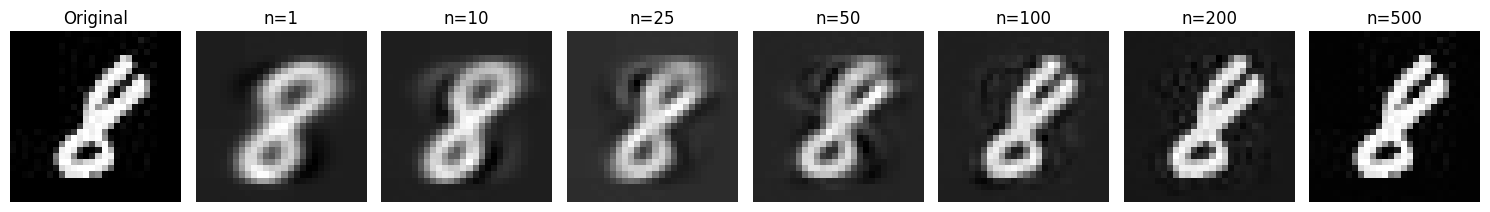

In [34]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

digit_8_images = data[8]

digit_8_flat = digit_8_images.reshape(digit_8_images.shape[0], -1)

n_components_list = [1, 10, 25, 50, 100,200,500]
plt.figure(figsize=(15, 3))


plt.subplot(1, len(n_components_list) + 1, 1)
plt.imshow(digit_8_images[0], cmap='gray')
plt.title('Original')
plt.axis('off')

# construction
for i, n_components in enumerate(n_components_list, 1):
    pca = PCA(n_components=n_components)
    pca_features = pca.fit_transform(digit_8_flat)
    reconstructed_images = pca.inverse_transform(pca_features)
    
    reconstructed_image = reconstructed_images[0].reshape(28, 28)
    
    plt.subplot(1, len(n_components_list) + 1, i + 1)
    plt.imshow(reconstructed_image, cmap='gray')
    plt.title(f'n={n_components}')
    plt.axis('off')

    reconstruction_error = np.mean((digit_8_flat[0] - reconstructed_images[0])**2)
    
    print("MSE error for",n_components, "components = ", reconstruction_error)

plt.tight_layout()
plt.show()


## Metrics

In [35]:
import torch
import numpy as np
import torch.nn.functional as F

def metrics_calc(y_true, y_pred):
    num_classes = 10
    confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)
    
    # Compute confusion matrix
    for x, y in zip(y_true, y_pred):
        confusion_matrix[x, y] += 1
    
    class_metrics = []
    
    for cls in range(num_classes):
        tp = confusion_matrix[cls, cls]
        fp = np.sum(confusion_matrix[:, cls]) - tp
        fn = np.sum(confusion_matrix[cls, :]) - tp
        tn = np.sum(confusion_matrix) - (tp + fp + fn)
        
        # Compute metrics
        accuracy = (tp + tn) / np.sum(confusion_matrix)
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        class_metrics.append({
            'Class': cls,
            'TP': tp,
            'TN': tn,
            'FP': fp,
            'FN': fn,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1_score
        })
    
    return confusion_matrix, class_metrics

images = data.reshape(-1, 28, 28)
labels = np.repeat(np.arange(10), 1000)

# split 
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)


X_train = torch.from_numpy(X_train).float().unsqueeze(1)
X_test = torch.from_numpy(X_test).float().unsqueeze(1)
y_train = torch.from_numpy(y_train).long()
y_test = torch.from_numpy(y_test).long()


batch_size = 64
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


cnn_model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.001)


epochs = 20
for epoch in range(epochs):
    cnn_model.train()
    curr_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = cnn_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        curr_loss += loss.item() * images.size(0)
    
    epoch_loss = curr_loss / len(train_loader.dataset)


cnn_model.eval()
predictions = []
true_labels = []


for images, labels in test_loader:
    outputs = cnn_model(images)
    _, pred = torch.max(outputs, 1)
    predictions.extend(pred.numpy())
    true_labels.extend(labels.numpy())


confusion_matrix, class_metrics = metrics_calc(np.array(true_labels), np.array(predictions))

print("Confusion Matrix:")
print(confusion_matrix)

# Print metrics for each class
print("\nClass-wise Metrics:")
for metrics in class_metrics:
    print(f"\nClass {metrics['Class']}:")
    for key, value in metrics.items():
        if key != 'Class':
            print(f"{key}: {value:.4f}")


macro_precision = np.mean([m['Precision'] for m in class_metrics])
macro_recall = np.mean([m['Recall'] for m in class_metrics])
macro_f1 = np.mean([m['F1 Score'] for m in class_metrics])

print("\nMacro-averaged Metrics:")
print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall: {macro_recall:.4f}")
print(f"Macro F1 Score: {macro_f1:.4f}")

Confusion Matrix:
[[199   0   0   0   0   0   1   0   0   0]
 [  0 194   2   0   2   0   0   0   0   2]
 [  0   1 197   0   0   0   0   2   0   0]
 [  1   0   2 193   0   2   0   0   2   0]
 [  0   0   2   0 197   0   0   0   0   1]
 [  0   0   0   0   0 195   2   0   3   0]
 [  2   0   0   0   0   0 198   0   0   0]
 [  0   0   1   0   3   0   0 193   0   3]
 [  1   0   0   0   0   1   3   0 195   0]
 [  1   0   1   0   2   1   0   0   0 195]]

Class-wise Metrics:

Class 0:
TP: 199.0000
TN: 1795.0000
FP: 5.0000
FN: 1.0000
Accuracy: 0.9970
Precision: 0.9755
Recall: 0.9950
F1 Score: 0.9851

Class 1:
TP: 194.0000
TN: 1799.0000
FP: 1.0000
FN: 6.0000
Accuracy: 0.9965
Precision: 0.9949
Recall: 0.9700
F1 Score: 0.9823

Class 2:
TP: 197.0000
TN: 1792.0000
FP: 8.0000
FN: 3.0000
Accuracy: 0.9945
Precision: 0.9610
Recall: 0.9850
F1 Score: 0.9728

Class 3:
TP: 193.0000
TN: 1800.0000
FP: 0.0000
FN: 7.0000
Accuracy: 0.9965
Precision: 1.0000
Recall: 0.9650
F1 Score: 0.9822

Class 4:
TP: 197.0000
TN:

In [60]:
import torch
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split


images = data.reshape(-1, 28, 28)
labels = np.repeat(np.arange(10), 1000)


X_train_img, X_test_img, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)

X_train_flat = X_train_img.reshape(X_train_img.shape[0], -1)
X_test_flat = X_test_img.reshape(X_test_img.shape[0], -1)

pca = PCA(n_components=50)
X_train_pca = pca.fit_transform(X_train_flat)
X_test_pca = pca.transform(X_test_flat)


# data for each model
# 1. MLP 
X_train_mlp = torch.from_numpy(X_train_flat).float()
X_test_mlp = torch.from_numpy(X_test_flat).float()
y_train_tensor = torch.from_numpy(y_train).long()
y_test_tensor = torch.from_numpy(y_test).long()

train_dataset_mlp = torch.utils.data.TensorDataset(X_train_mlp, y_train_tensor)
test_dataset_mlp = torch.utils.data.TensorDataset(X_test_mlp, y_test_tensor)
test_loader_mlp = torch.utils.data.DataLoader(test_dataset_mlp, batch_size=64, shuffle=False)

# 2. CNN 
X_train_cnn = torch.from_numpy(X_train_img).float().unsqueeze(1)
X_test_cnn = torch.from_numpy(X_test_img).float().unsqueeze(1)

train_dataset_cnn = torch.utils.data.TensorDataset(X_train_cnn, y_train_tensor)
test_dataset_cnn = torch.utils.data.TensorDataset(X_test_cnn, y_test_tensor)
test_loader_cnn = torch.utils.data.DataLoader(test_dataset_cnn, batch_size=64, shuffle=False)

# 3. PCA 
X_train_pca_tensor = torch.from_numpy(X_train_pca).float()
X_test_pca_tensor = torch.from_numpy(X_test_pca).float()

train_dataset_pca = torch.utils.data.TensorDataset(X_train_pca_tensor, y_train_tensor)
test_dataset_pca = torch.utils.data.TensorDataset(X_test_pca_tensor, y_test_tensor)
test_loader_pca = torch.utils.data.DataLoader(test_dataset_pca, batch_size=64, shuffle=False)


def goodness(model, test_loader, model_name):
    model.eval()
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for data, labels in test_loader:
            outputs = model(data)
            temp, preds = torch.max(outputs, 1)
            predictions.extend(preds.numpy())
            true_labels.extend(labels.numpy())
    
    cm, metrics = metrics_calc(np.array(true_labels), np.array(predictions))
    
    print(f"\n{model_name} Confusion Matrix:")
    print(cm)
    
    print("\n")
    
    for m in metrics:
        print(f"Class {m['Class']}: "
              f"Precision={m['Precision']:.4f}, "
              f"Recall={m['Recall']:.4f}, "
              f"F1={m['F1 Score']:.4f}")
    
    print(f"\n{model_name} Overall Averages:")
    print(f"Precision: {np.mean([m['Precision'] for m in metrics]):.4f}")
    print(f"Recall: {np.mean([m['Recall'] for m in metrics]):.4f}")
    print(f"F1: {np.mean([m['F1 Score'] for m in metrics]):.4f}")


# calling goodness function for performance check
goodness(Neural_Network, test_loader_mlp, "MLP")
goodness(cnn_model, test_loader_cnn, "CNN")
goodness(mlp_pca_model, test_loader_pca, "MLP+PCA")
goodness(logistic_model, test_loader_pca, "Logistic Regression+PCA")


MLP Confusion Matrix:
[[200   0   0   0   0   0   0   0   0   0]
 [  0 199   0   0   0   0   0   0   1   0]
 [  0   1 199   0   0   0   0   0   0   0]
 [  1   0   0 188   0   1   0   0   0  10]
 [  0   0   0   0 195   0   0   0   0   5]
 [  0   0   0   0   0 196   0   0   2   2]
 [  1   0   1   0   1   2 193   0   2   0]
 [  0   1   0   0   1   0   0 197   0   1]
 [  1   0   0   0   0   0   0   0 198   1]
 [  1   0   0   0   4   0   0   0   0 195]]


Class 0: Precision=0.9804, Recall=1.0000, F1=0.9901
Class 1: Precision=0.9900, Recall=0.9950, F1=0.9925
Class 2: Precision=0.9950, Recall=0.9950, F1=0.9950
Class 3: Precision=1.0000, Recall=0.9400, F1=0.9691
Class 4: Precision=0.9701, Recall=0.9750, F1=0.9726
Class 5: Precision=0.9849, Recall=0.9800, F1=0.9825
Class 6: Precision=1.0000, Recall=0.9650, F1=0.9822
Class 7: Precision=1.0000, Recall=0.9850, F1=0.9924
Class 8: Precision=0.9754, Recall=0.9900, F1=0.9826
Class 9: Precision=0.9112, Recall=0.9750, F1=0.9420

MLP Overall Averages:
P

## ROC and AUC

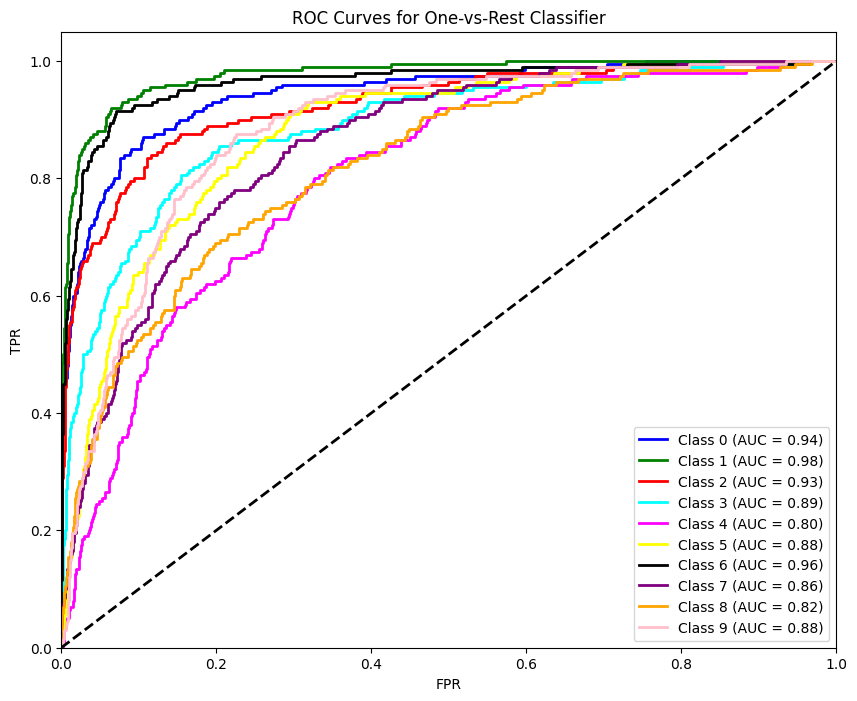

Average AUC: 0.8828


In [47]:
from sklearn.metrics import roc_curve, auc
import numpy as np


ovr_classifier.classifiers = [c.eval() for c in ovr_classifier.classifiers] 

scores = []
true = []
with torch.no_grad():
    for images, labels in test_loader:
        batch_scores = []
        for i in range(10):
            outputs = ovr_classifier.classifiers[i](images).squeeze()
            batch_scores.append(outputs.numpy())
        batch_scores = np.stack(batch_scores, axis=1)
        scores.append(batch_scores)
        true.append(labels.numpy())
scores = np.concatenate(scores, axis=0)
true = np.concatenate(true, axis=0)


plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'purple', 'orange', 'pink'] # used gpt to generate this
for i in range(10):
    fpr, tpr, temp = roc_curve((true == i).astype(int), scores[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i], lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curves for One-vs-Rest Classifier')
plt.legend(loc="lower right")
plt.show()

average_auc = np.mean([auc(fpr, tpr) for i in range(10)])
print(f"Average AUC: {average_auc:.4f}")